<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/lab_tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)


## Example of Classification by CNN

The following shows an example code of Convolutional Neural Network (CNN) for classification of mnist data, which is implemented by using PyTorch.

At first, the necessary packages are imported. Then availability of cuda is checked.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import Tensor
import torch.nn.functional as F
%matplotlib inline

print('torch version is {}'.format(torch.__version__))
if torch.cuda.is_available():
    print('cuda is available')
else:
    print('cuda is not available')

torch version is 1.7.1
cuda is available


The following code is to fix the seed values for random numbers.

Since the initial value of the weight is determined by random numbers, it is better to fix the seed values. By fixing the seed value of the random number, you can get the same results. Otherwise, you will get different results depending on the initial value. We have to fix the following three different seeds.

In [2]:
torch.cuda.manual_seed_all(100100)
torch.manual_seed(100100)
np.random.seed(100100)

Then the MNIST data set are loaded.

The image samples for the training and the test are stored in x_train and x_test. The labels for the training and the test are stored in y_train and y_test.

The input image to our CNN model should have the shape of $(N, C, H, W)$, where 

$N:$ number of data

$C:$ number of channnel

$H:$ height

$W:$ width

This part should be appropriately rewritten if you want to use other network architecture or other data.

In [3]:
mnist_train = dsets.MNIST("./data", download=True, train=True)
x_train = []
y_train = []
x_test = []
y_test = []

mnist_test = dsets.MNIST("./data", download=True, train=False)

for i in range(len(mnist_train)):
	x_train.append(np.array(mnist_train[i][0]))
	y_train.append(mnist_train[i][1])

for i in range(len(mnist_test)):
	x_test.append(np.array(mnist_test[i][0]))
	y_test.append(mnist_test[i][1])

# Change shape of the x_train and x_test to (N, C, H, W) by reshape.
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.reshape(len(mnist_train), 1, 28, 28)
x_train = x_train / 255.0

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(len(mnist_test), 1, 28, 28)
x_test = x_test / 255.0

datasize = len(y_train)
datasize_test = len(y_test)

print('Shape of x_train\n', x_train.shape)
print('Shape of x_test\n', x_test.shape)

Shape of x_train
 (60000, 1, 28, 28)
Shape of x_test
 (10000, 1, 28, 28)


The following code is to define the network architecture.

The computation within the convolution layers is regarded as a filtering process of the input image as
\begin{align}
f_{p,q}^{(c)}=h(\sum^{convy-1}_{r=0}\sum^{convx-1}_{s=0}w^{(c)}_{r,s}f^{(c-1)}_{p+r, q+s}+b^{(c)}) \; ,
\end{align}

where $w^{(c)}_{r,s}$ is the weight of the neuron indexed as $(r,s)$ in the $c$-th convolution layer and $b^{(c)}$ is the bias of the $c$-th convolution layer. 

The size of the convolution filter is given as $convx \times convy$. The activation function of each neuron is denoted as $h$. 

Usually, pooling layers are added after the convolution layers. The pooling layer performs downsampling for reducing computational costs and enhancing against micro position changes. 

Fully-connected layers like multi layer perceptron is connected to the convolution layers which is used to construct the classifier. 

In this example, a model of the following structure is defined.


---

convolution layer1:(filtersize:3*3, channel:32)

convolution layer2:(filtersize:3*3, channel:32)

full connected:(128)


---



In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
if torch.cuda.is_available():
  net.cuda()

print('Network architecture for CNN\n', net)

Network architecture for CNN
 Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


The following code defines the loss function for parameter optimization.

The cross entropy loss is defined as the following equation.

\begin{align}
E = -\sum_n^N {\boldsymbol t}_n^Tlog(S({\boldsymbol y}_n)) \; 
\end{align}

where $S(\cdot)$ is an activation function of the output layer, ${\boldsymbol t_n}$ is a label and ${\boldsymbol y_n}$ is the output of the network.

The softmax function is generally used for multiclass classification tasks and is defined by using the output values of the output layer.

In [5]:
softmax_cross_entropy = nn.CrossEntropyLoss()

The following code define the optimizer to train the parameters of the network. 

In this example, the stochastic gradient descent method with momentum (SGD with momentum) is used. This is the most fundamental optimization algorithm for neural network learning.

We have to specify the hyper-parameters $\mu$ and $\eta$, where $\mu$ is a learning rate and $\eta$ is a momentum parameter.

The update rule of the optimization is given as
\begin{align}
{\boldsymbol w}^{(t+1)} &\leftarrow {\boldsymbol w}^{(t)} + \Delta  {\boldsymbol w}^{(t)} \\
 \Delta  {\boldsymbol w}^{(t)} &= \mu \Delta {\boldsymbol w}^{(t - 1)} - (1-\mu) \eta {\boldsymbol g}^{(t)} \\
 {\boldsymbol g}^{(t)} &= \nabla E({\boldsymbol w}^{(t)})
 \end{align}
 
In addition, the regularization terms such as weight decay may be added as necessary to prevent over-learning. In the following code, the parameter of the weight_decay is set to 0.005.


In [6]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

Then we can train the parameters of the network.
In the following code, a set of input images are feeded to the input of the into the model and the parameters (weights) of the network are trained by using the optimization algorithm. The set of samples are called mini-batch.

After all the samples in the training set are feeded to the network (at each epoch), the loss and the accuracy for the training samples and the test samples are evaluated.

In [7]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

#define batch-size and epoch.
epoch=100
batchsize=100

for epoch in range(1, epoch+1):
	print('epoch', epoch)
	perm = np.random.permutation(datasize)
	for i in range(0, datasize, batchsize):
		#Create mini-batch.
		x_batch = x_train[perm[i:i+batchsize]]
		y_batch = y_train[perm[i:i+batchsize]]
    
		#Convert a numpy array to a tensor to do gradient calculations.
		if torch.cuda.is_available():
			x_batch = torch.from_numpy(x_batch).float().cuda()
			y_batch = torch.from_numpy(y_batch).long().cuda()
		else:
			x_batch = torch.from_numpy(x_batch).float()
			y_batch = torch.from_numpy(y_batch).long()

		#Initialize the stored gradient.
		optimizer.zero_grad()

		#Get the model output for the input mini-batch.
		y = net(x_batch)
    
		#Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
		loss = softmax_cross_entropy(y, y_batch)  
    
		#From loss, calculate the gradient of each parameter.
		loss.backward()

		#Each parameter is updated from the calculated gradient.
		optimizer.step()

	sum_score = 0
	sum_loss = 0
  
	#Evaluate the model with train data.
	for i in range(0, datasize, batchsize):
		x_batch = x_train[i:i+batchsize]
		y_batch = y_train[i:i+batchsize]
		if torch.cuda.is_available():
			x_batch = torch.from_numpy(x_batch).float().cuda()
			y_batch = torch.from_numpy(y_batch).long().cuda()
		else:
			x_batch = torch.from_numpy(x_batch).float()
			y_batch = torch.from_numpy(y_batch).long()
		y = net(x_batch)
		loss = softmax_cross_entropy(y, y_batch)
		sum_loss += float(loss.cpu().data.item()) * batchsize
		_, predict = y.max(1)
		sum_score += predict.eq(y_batch).sum().item()
	print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
	train_loss.append(sum_loss / datasize)
	train_acc.append(sum_score / datasize)
 
	sum_score = 0
	sum_loss = 0

	#Evaluate the model with test data.
	for i in range(0, datasize_test, batchsize):
		x_batch = x_test[i:i+batchsize]
		y_batch = y_test[i:i+batchsize]
		if torch.cuda.is_available():
			x_batch = torch.from_numpy(x_batch).float().cuda()
			y_batch = torch.from_numpy(y_batch).long().cuda()
		else:
			x_batch = torch.from_numpy(x_batch).float()
			y_batch = torch.from_numpy(y_batch).long()
		y = net(x_batch)
		loss = softmax_cross_entropy(y, y_batch)
		sum_loss += float(loss.cpu().data.item()) * batchsize
		_, predict = y.max(1)
		sum_score += predict.eq(y_batch).sum().item()
	print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
	test_loss.append(sum_loss / datasize_test)
	test_acc.append(sum_score / datasize_test)


epoch 1
	train  mean loss=0.13163353868139288, accuracy=0.9606666666666667
	test  mean loss=0.12286020616069436, accuracy=0.9626
epoch 2
	train  mean loss=0.0913506926363334, accuracy=0.9724666666666667
	test  mean loss=0.0824211274064146, accuracy=0.9733
epoch 3
	train  mean loss=0.07234681084752083, accuracy=0.9790333333333333
	test  mean loss=0.06361086544580757, accuracy=0.9808
epoch 4
	train  mean loss=0.07879789466271177, accuracy=0.9767666666666667
	test  mean loss=0.07377165339887143, accuracy=0.9763
epoch 5
	train  mean loss=0.0690153561051314, accuracy=0.9801666666666666
	test  mean loss=0.06630659587914124, accuracy=0.9801
epoch 6
	train  mean loss=0.06348811621389662, accuracy=0.98225
	test  mean loss=0.06362764092860744, accuracy=0.9799
epoch 7
	train  mean loss=0.08031817104201763, accuracy=0.9757166666666667
	test  mean loss=0.0763967098435387, accuracy=0.9759
epoch 8
	train  mean loss=0.06156973093127211, accuracy=0.9833333333333333
	test  mean loss=0.06015235528000631,

The followin code draws a graph of training curve (loss).

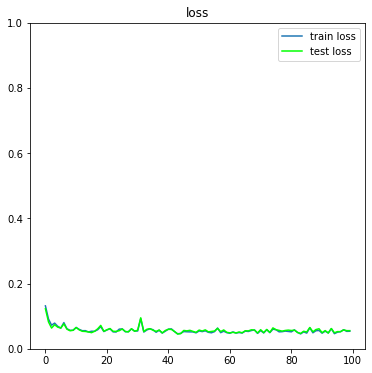

In [8]:
plt.figure(figsize=(6,6))

plt.ylim(0,1.0)
plt.plot(range(epoch), train_loss)
plt.plot(range(epoch), test_loss, c='#00ff00')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.show()

The following code draws the graph of training curve (accuracy).

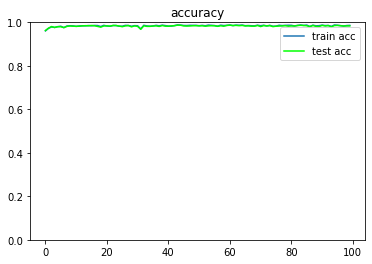

In [9]:
plt.plot(range(epoch), train_acc)
plt.plot(range(epoch), test_acc, c='#00ff00')
plt.ylim(0,1.0)
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.show()

## Visualization of the weights

It is necessary to modify the code to visualize the weights of the middle layer. In this section how to write codes to get some of the weights in the network is explained.

First example is to visualize some weights from the input layers to the middle layer.

Let's take a look at the unit connection weight, which uses the upper left value of the feature map as input.



In [10]:
net = Network()
if torch.cuda.is_available():
  net.cuda()

print('network architecture\n', net)

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

network architecture
 Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
weight_num = 10


#define batch-size and epoch.
epoch=100
batchsize=100

#Defines an array that holds the weight for each epoch.
train_weight = np.zeros((epoch, weight_num))

#Specify the weight to be visualized.
#Specify hidden layer unit j.
rum_num = np.array([0,15,30,45,60,75,90,105,120,127])

#Specify input layer unit i.
perm_num = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#The weight w_ij connecting the input layer unit i and the hidden layer unit j is acquired.


for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
      x_batch = torch.from_numpy(x_batch).float()
      y_batch = torch.from_numpy(y_batch).long()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
    
  #Extract weight values from the model.
  weight = net.fc1.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[rum_num[i]][perm_num[i]]
    train_weight[epoch-1][i] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
      x_batch = torch.from_numpy(x_batch).float()
      y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
      x_batch = torch.from_numpy(x_batch).float()
      y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
	train  mean loss=0.4932001785188913, accuracy=0.8588666666666667
	test  mean loss=0.47732448488473894, accuracy=0.8663
epoch 2
	train  mean loss=0.3052695827248196, accuracy=0.9093
	test  mean loss=0.2944743882119656, accuracy=0.9146
epoch 3
	train  mean loss=0.252559139461567, accuracy=0.9252
	test  mean loss=0.2442118526250124, accuracy=0.9297
epoch 4
	train  mean loss=0.20468140772233406, accuracy=0.9385333333333333
	test  mean loss=0.1907472806237638, accuracy=0.9422
epoch 5
	train  mean loss=0.1703496214405944, accuracy=0.9500666666666666
	test  mean loss=0.16485708702355623, accuracy=0.9511
epoch 6
	train  mean loss=0.14795853313369056, accuracy=0.9561333333333333
	test  mean loss=0.13885783575475216, accuracy=0.9585
epoch 7
	train  mean loss=0.1296824371209368, accuracy=0.9618
	test  mean loss=0.12200157452374696, accuracy=0.963
epoch 8
	train  mean loss=0.12326883210490147, accuracy=0.9631
	test  mean loss=0.11432354527991265, accuracy=0.9652
epoch 9
	train  mean loss=

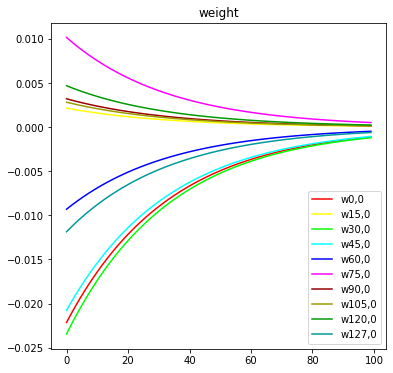

In [12]:
plt.figure(figsize=(6,6))
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

#Plot the obtained weights on a graph.
train_weight = train_weight.transpose(1,0)
for i in range(weight_num):
  plt.plot(range(epoch), train_weight[i], c=c[i])
plt.legend(['w0,0', 'w15,0', 'w30,0', 'w45,0', 'w60,0', 'w75,0', 'w90,0', 'w105,0', 'w120,0', 'w127,0'])
plt.title('weight')
plt.show()

From this graph, it is noticed that all the unit connection weights are conversing to 0.

That means that the value of the unit with index 0 in the input layer is rarely used.

Next, we visualize the weigts of the convolution filters of the first layer.

In [13]:
net = Network()
if torch.cuda.is_available():
  net.cuda()

print('network architecture\n', net)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

network architecture
 Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

#define batch-size and epoch.
epoch=100
batchsize=100

#Specify the weight to be visualized.
#Specify the input channel.
inputc_num = np.array([0,0,0])

#Specify the output channel.
outputc_num = np.array([0,16,31])

#Defines an array that holds the weight for each epoch.
weight_num = int(len(inputc_num))
k_size = int(net.conv1.weight.cpu().detach().numpy().shape[2])
train_weight = np.zeros((weight_num, epoch, k_size*k_size))

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  #Extract weight values from the model.
  weight = net.conv1.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[outputc_num[i]][inputc_num[i]]
    weight0 = weight0.flatten()
    train_weight[i][epoch-1] = weight0

  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)

  sum_score = 0
  sum_loss = 0

  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
	train  mean loss=0.13277012070640923, accuracy=0.9609
	test  mean loss=0.12545046966522932, accuracy=0.9628
epoch 2
	train  mean loss=0.0989594528855135, accuracy=0.9697833333333333
	test  mean loss=0.08887665460584686, accuracy=0.9721
epoch 3
	train  mean loss=0.07210572472540662, accuracy=0.979
	test  mean loss=0.06754102370352484, accuracy=0.9793
epoch 4
	train  mean loss=0.07006699675073226, accuracy=0.9805
	test  mean loss=0.06621094023110345, accuracy=0.9803
epoch 5
	train  mean loss=0.06260473981810112, accuracy=0.9821166666666666
	test  mean loss=0.05829176607076079, accuracy=0.9814
epoch 6
	train  mean loss=0.056312292134389284, accuracy=0.9848166666666667
	test  mean loss=0.05665643531247042, accuracy=0.9825
epoch 7
	train  mean loss=0.0666307017665046, accuracy=0.981
	test  mean loss=0.0638864649203606, accuracy=0.9815
epoch 8
	train  mean loss=0.05939122784029072, accuracy=0.9832
	test  mean loss=0.05923102548229508, accuracy=0.9823
epoch 9
	train  mean loss=0.0909

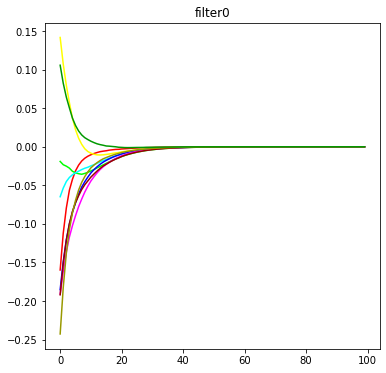

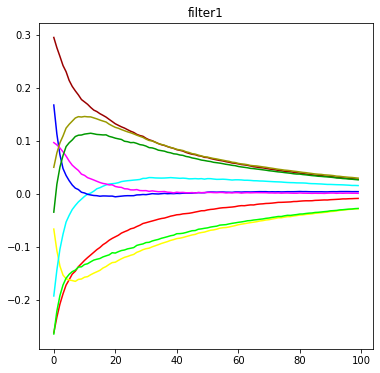

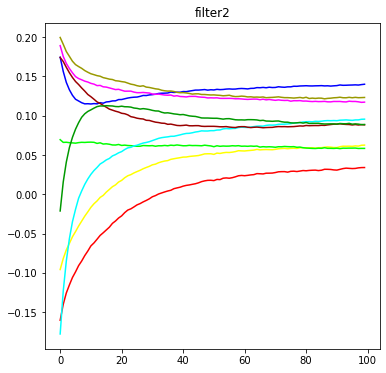

In [15]:
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

for i in range(weight_num):
  plt.figure(figsize=(6,6))
  p = train_weight[i]
  p = p.transpose(1,0)
  for j in range(k_size*k_size):
    plt.plot(range(epoch), p[j], c=c[j])
  plt.title('filter%d'%i)
  plt.show()

Next, we visualize the weigts of the convolution filters of the second layer.

In [16]:
net = Network()
if torch.cuda.is_available():
  net.cuda()

print('network architecture\n', net)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

network architecture
 Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [17]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

#define batch-size and epoch.
epoch=100
batchsize=100

#Specify the weight to be visualized.
#Specify the input channel.
inputc_num = np.array([0,16,25])

#Specify the output channel.
outputc_num = np.array([0,16,25])

weight_num = int(len(inputc_num))
k_size = int(net.conv2.weight.cpu().detach().numpy().shape[2])

train_weight = np.zeros((weight_num, epoch, k_size*k_size))

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  #Extract weight values from the model.
  weight = net.conv2.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[outputc_num[i]][inputc_num[i]]
    weight0 = weight0.flatten()
    train_weight[i][epoch-1] = weight0

  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)

  sum_score = 0
  sum_loss = 0

  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
	train  mean loss=0.13538352346047758, accuracy=0.9607666666666667
	test  mean loss=0.12347947488538921, accuracy=0.9623
epoch 2
	train  mean loss=0.08372647652945792, accuracy=0.9767
	test  mean loss=0.07770075911656021, accuracy=0.9768
epoch 3
	train  mean loss=0.07881319370275984, accuracy=0.9766666666666667
	test  mean loss=0.0736612193332985, accuracy=0.9782
epoch 4
	train  mean loss=0.06785975913750007, accuracy=0.9798333333333333
	test  mean loss=0.06474212804809212, accuracy=0.9799
epoch 5
	train  mean loss=0.06229528857084612, accuracy=0.9829166666666667
	test  mean loss=0.06141932890051976, accuracy=0.9825
epoch 6
	train  mean loss=0.06738100171244393, accuracy=0.9801333333333333
	test  mean loss=0.06543608292704448, accuracy=0.9803
epoch 7
	train  mean loss=0.06770894687622786, accuracy=0.9808666666666667
	test  mean loss=0.0640392269194126, accuracy=0.9819
epoch 8
	train  mean loss=0.06404842897007863, accuracy=0.9827166666666667
	test  mean loss=0.0648859369312413,

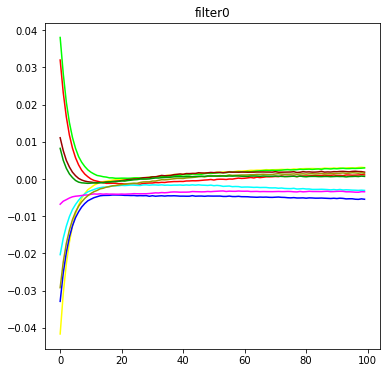

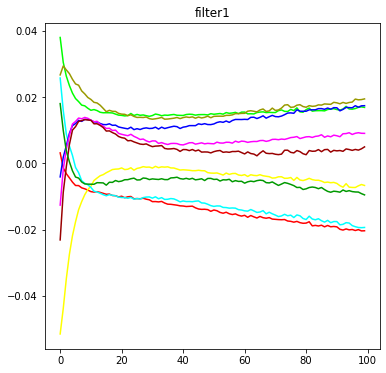

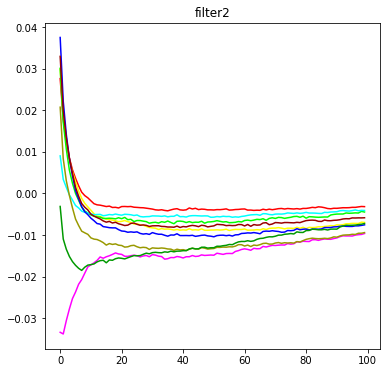

In [18]:
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

#Plot the obtained weights on a graph.
for i in range(weight_num):
  plt.figure(figsize=(6,6))
  p = train_weight[i]
  p = p.transpose(1,0)
  for j in range(k_size*k_size):
    plt.plot(range(epoch), p[j], c=c[j])
  plt.title('filter%d'%i)
  plt.show()

Also the weight seems conversing to 0.
It may be the effect of weight decay that some filter weight values are approaching zero.

You can also see the change in weight when not using weight decay.

## Visualization of the feature maps in the middle layer of the network

Next, let's take out the feature map of the middle layer and visualize the feature maps.

At first, we extract the feature map from the first convolution layer.

In [19]:
datasize = 100
batchsize = 10
result = np.zeros((datasize, 32, 28, 28))

for i in range(0, datasize, batchsize):
	x_batch = x_train[i:i+batchsize]
	if torch.cuda.is_available():
		x_batch = torch.from_numpy(x_batch).float().cuda()
	else:
		x_batch = torch.from_numpy(x_batch).float()
	fmap = net.conv1(x_batch)
	result[i:i+batchsize] = fmap.cpu().detach().numpy()


The extracted feature map is visualized in as images.

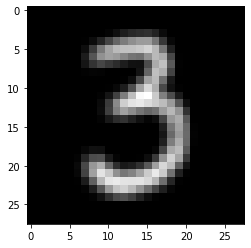

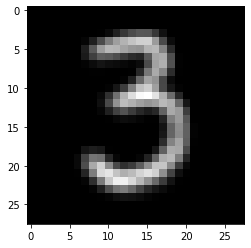

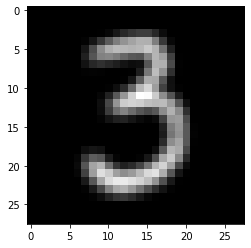

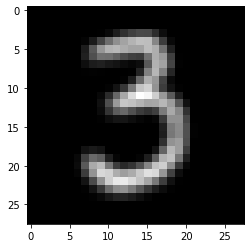

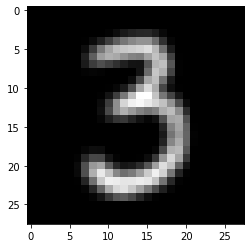

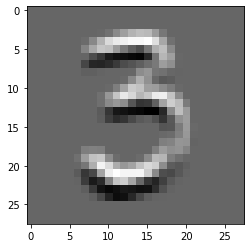

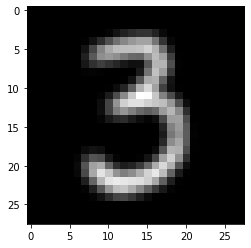

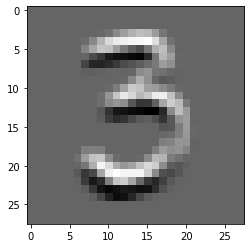

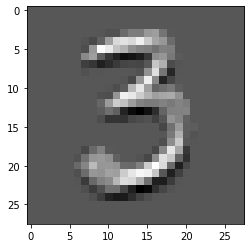

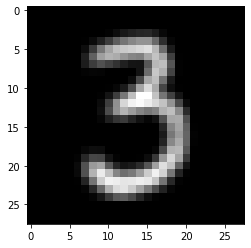

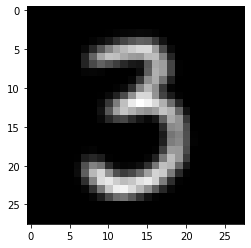

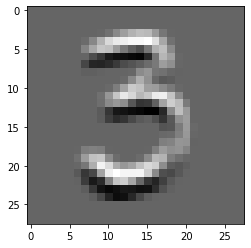

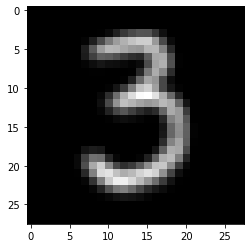

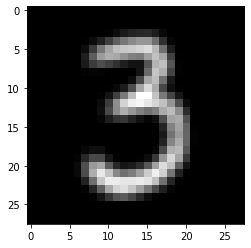

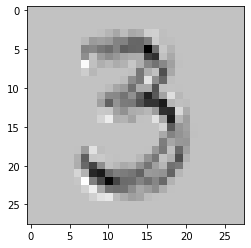

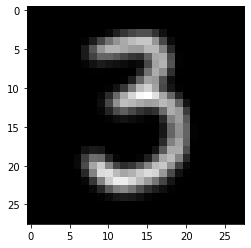

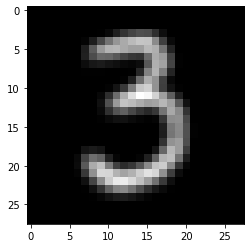

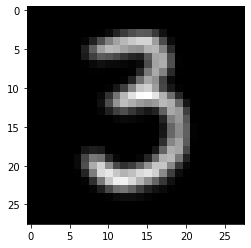

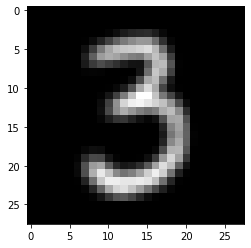

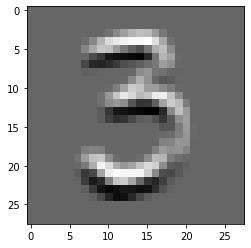

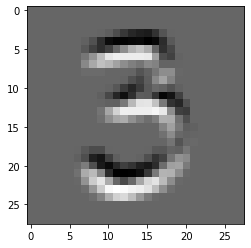

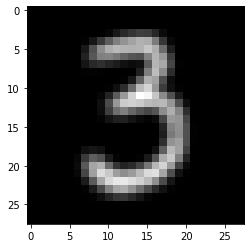

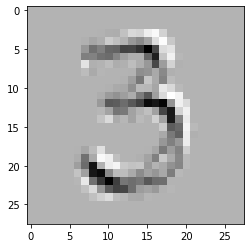

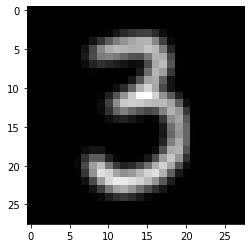

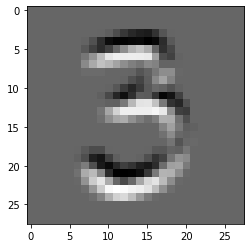

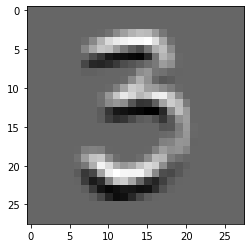

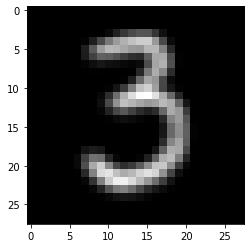

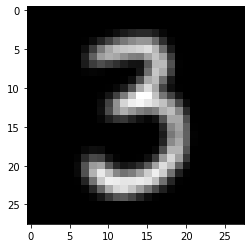

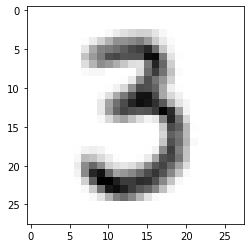

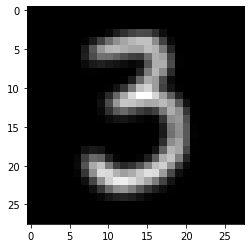

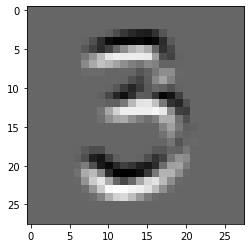

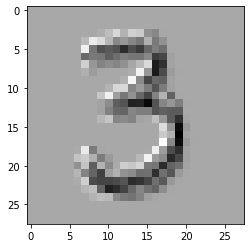

In [20]:
#Specify the index of the image you want to display.
index = 50

for i in range(32):
  pic = result[index]
  pic = pic[i]
  pic= pic.reshape((28,28))
  plt.imshow(pic)
  plt.gray()
  plt.show()


Next, extract the feature map obtained from the second layer of convolution.

In [21]:
result = np.zeros((datasize, 32, 28, 28))

for i in range(0, datasize, batchsize):
	x_batch = x_train[i:i+batchsize]
	if torch.cuda.is_available():
		x_batch = torch.from_numpy(x_batch).float().cuda()
	else:
		x_batch = torch.from_numpy(x_batch).float()
	fmap = net.conv1(x_batch)
	fmap = net.conv2(fmap)
	result[i:i+batchsize] = fmap.cpu().detach().numpy()


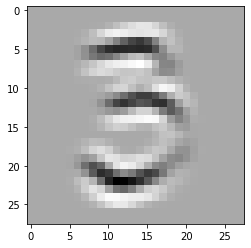

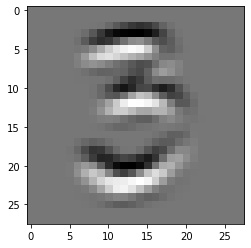

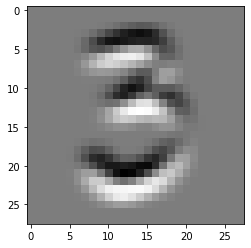

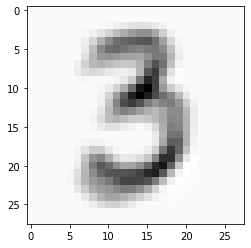

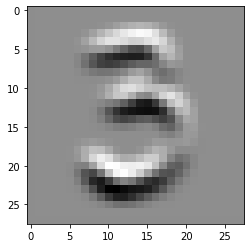

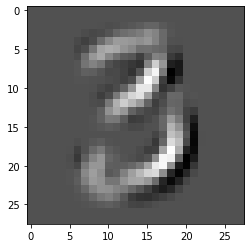

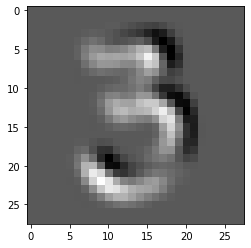

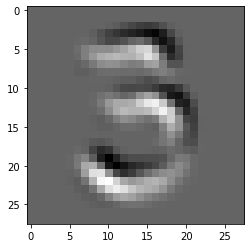

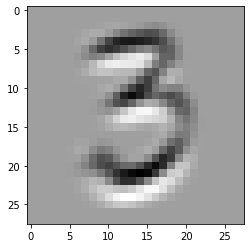

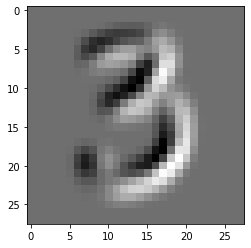

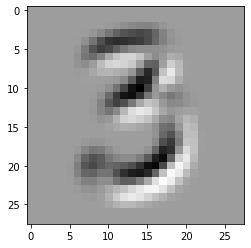

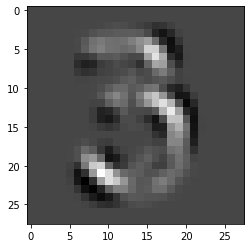

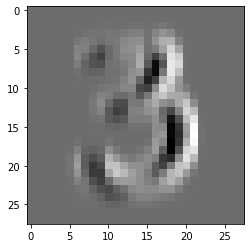

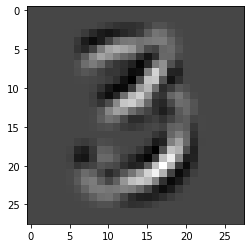

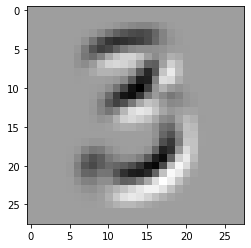

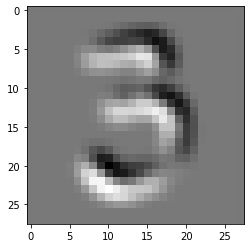

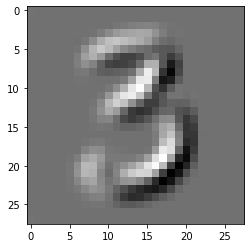

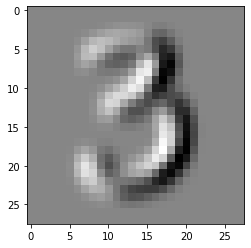

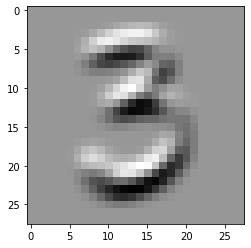

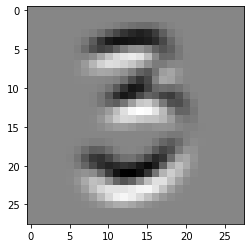

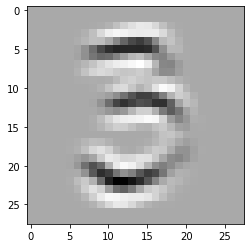

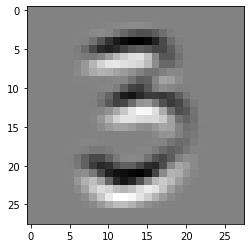

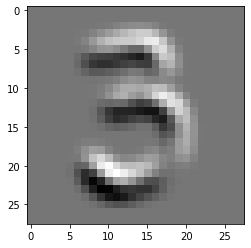

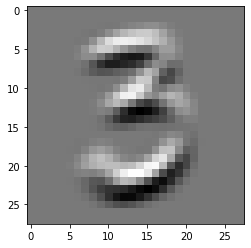

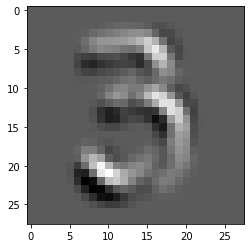

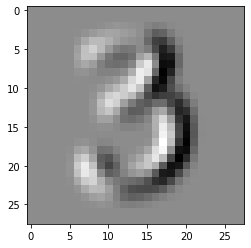

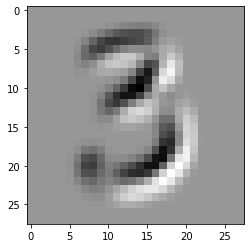

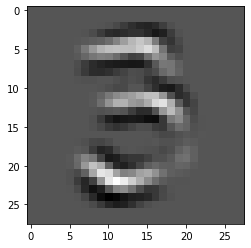

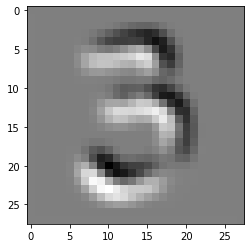

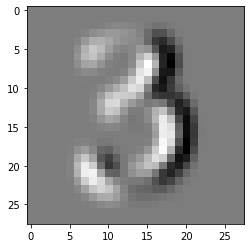

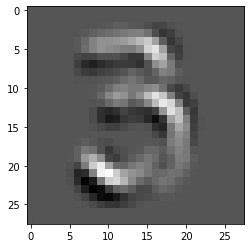

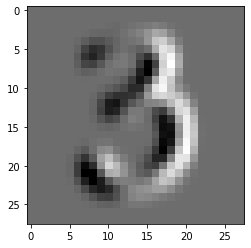

In [22]:
#Specify the index of the image you want to display.
index = 50


for i in range(32):
  pic = result[index]
  pic = pic[i]
  pic= pic.reshape((28,28))
  plt.imshow(pic)
  plt.gray()
  plt.show()

Each feature map shows that edge extraction has been performed.